# ** TRIPLET CHNAGE ** 

In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np 
import matplotlib.patches as mpatches
import json
import pandas as pd
from datetime import datetime

In [2]:
plt.style.use("seaborn-ticks")

In [3]:
#whole genome doubled model
model = json.load(open("../Human_mutability_model/Model_2020_12_02_genomeWide.txt"))

In [4]:
file_path_afterSim = "data/dif_DNA/"
sim_name_afterSim = "Trial"
about_sim = "_cds_invariant50"
nTrials= 10 #
gen_to_use = 600000

In [5]:
DNA_dataDict = {}

#DifDNA800kgen trial 1-5
for index_tmp in range(1,int(nTrials)+1):
    file_name_exondict = sim_name_afterSim+str(index_tmp)+"_exon_insertion_dict.txt"
    file_name_dnaI = sim_name_afterSim+str(index_tmp)+"_DNA_gen0_cds.txt"
    file_name_dnaF = sim_name_afterSim+str(index_tmp)+"_DNA_final"+about_sim+"_"+str(gen_to_use)+".txt"
    file_name_dnamap = sim_name_afterSim+str(index_tmp)+"_DNA_map"+about_sim+".txt"
    
    file_object_exondict = json.loads(open(file_path_afterSim+file_name_exondict).readlines()[0])
    file_object_dnaI = open(file_path_afterSim+file_name_dnaI).readlines()[0]
    file_object_dnaF = open(file_path_afterSim+file_name_dnaF).readlines()[0]
    file_object_dnamap = open(file_path_afterSim+file_name_dnamap).readlines()[0]
    
    DNA_dataDict["Trial"+str(index_tmp)] = [file_object_dnaI, file_object_dnaF, file_object_dnamap, file_object_exondict]
    
#adding codonsI and codonsF list to the dna_data dictionary 
for trial_number in range(1,nTrials+1):
    trial_name = "Trial"+str(trial_number)

    current_DNAI = DNA_dataDict[trial_name][0]
    current_DNAF = DNA_dataDict[trial_name][1]
    current_codonsI = []
    current_codonsF = []

    tmp_nCodons = 0

    for exon_bounds_list in DNA_dataDict[trial_name][3].values():

        i = int(exon_bounds_list[0])+1

        tmp_exon_codons = int((int(exon_bounds_list[1]) - int(exon_bounds_list[0]))/3)
        tmp_nCodons += tmp_exon_codons


        while i <= int(exon_bounds_list[1]): 
            current_codonsI.append(current_DNAI[i:i+3])
            current_codonsF.append(current_DNAF[i:i+3])
            i+= 3
    
    DNA_dataDict[trial_name].extend([current_codonsI, current_codonsF])
    
#adding intronic triplet counts to the dictionary dna_datadict
for trial_number in range(1,nTrials+1):
    trial_name = "Trial"+str(trial_number)
    
    #turning the exon iseertion dictionary into an ordered list of bounds 
    all_exon_bounds_list = []
    for current_exon_bounds_list in DNA_dataDict[trial_name][3].values():
        all_exon_bounds_list.append(int(current_exon_bounds_list[0]))
        all_exon_bounds_list.append(int(current_exon_bounds_list[1]))    
    all_exon_bounds_list.sort()
    all_exon_bounds_list = [0]+all_exon_bounds_list[0:-1] #dont want the last bound as my dna end in exon 

    current_allIntronTriplets_initial  = []
    current_allIntronTriplets_final  = []

    for start_bound_index in range(0,len(all_exon_bounds_list),2): 
        start_bound = all_exon_bounds_list[start_bound_index]
        end_bound = all_exon_bounds_list[start_bound_index+1]
        for site in range(start_bound+1,end_bound-1): 

            tripletI = DNA_dataDict[trial_name][0][site-1:site+2]
            current_allIntronTriplets_initial.append(tripletI)

            tripletF = DNA_dataDict[trial_name][1][site-1:site+2]
            current_allIntronTriplets_final.append(tripletF)
        
    
    DNA_dataDict[trial_name].extend([current_allIntronTriplets_initial, current_allIntronTriplets_final])

DNA_dataDict["Trial"+str(index_tmp)] = 
0. file_object_dnaI, (dna string)
1. file_object_dnaF, (dna string)
2. file_object_dnamap, (dna map string)
3. file_object_exondict (dictionary) 
4. current_codonsI,  (list) 
5. current_codonsF (list) 
6. intronic triplet initial (list)
7. intronic triplet final (list) 

** building the list for triplet counts **

In [32]:
triplets = []
for key in model.keys(): 
    triplets.append(key)

In [38]:
#muts 
muts = []
for triplet in triplets: 
    muts.append(model[triplet][0])
    
muts_log10 = []
for mut in muts: 
    muts_log10.append(np.log(mut))

In [36]:
#making the counts dictionary (proportion of the # that you started with --> proportional chnage )
intron_counts_dict = {}
for triplet in triplets: 
    
    intron_counts_dict[triplet] = []
    
    for trial_number in range(1,nTrials+1):
        trial_name = "Trial"+str(trial_number)
        
        triplet_countI = DNA_dataDict[trial_name][6].count(triplet)
        triplet_countF = DNA_dataDict[trial_name][7].count(triplet)
        
        intron_counts_dict[triplet].append((triplet_countF- triplet_countI)/triplet_countI) 

# MAKING THE MEAN AND STD LISTS 
triplet_muts_intron = []
triplet_chnage_mean_intron = []
triplet_chnage_std_intron = []

for triplet in triplets: 
    triplet_muts_intron.append(model[triplet][0])        
    triplet_chnage_mean_intron.append(np.mean(intron_counts_dict[triplet]))
    triplet_chnage_std_intron.append(np.std(intron_counts_dict[triplet])/np.sqrt(nTrials))

In [37]:
#precursor mut 
precursor_mut_prob = []
bases = ["A", "T", "G", "C"]
for triplet in triplets: 
    current_weight_mut =[]
    
    for middle_base in bases: 
        from_triplet = triplet[0]+middle_base+triplet[2]
        
        if from_triplet != triplet: 
            current_mut = model[from_triplet][0]
            current_prob =model[from_triplet][1][triplet]
            current_weight_mut.append(current_mut*current_prob)
            
    precursor_mut_prob.append(np.mean(current_weight_mut))
        

In [41]:
## adj mut 
adj_both_1around_mut = []
for triplet in triplets: 
    adj_both_1around_mut.append(adj_mut_calc(triplet))


In [40]:
def adj_mut_calc(dna): 
    """
    string --> float 
    takes a TRIPLET
    calulates the mutability for ALL POSSIBLE triplets (equal weights) adjacent 
    """
    muts_leftadj = []
    muts_rightadj = []
    #piece for triplet -1 relative index 
    piece_leftadj = dna[0:2]
    for base in ["A", "T", "G", "C"]: 
        triplet_leftadj = base+piece_leftadj
        if triplet_leftadj in model: 
            muts_leftadj.append(model[triplet_leftadj][0])
        else: 
            muts_leftadj.append(model[reverse_complement(triplet_leftadj)][0])
#     #for triplets -2 relative index         
#     piece_leftadj =  dna[0:1]
#     for base1 in ["A", "T", "G", "C"]: 
#         for base2 in ["A", "T", "G", "C"]: 
#             triplet_leftadj = base1+base2+piece_leftadj
#             if triplet_leftadj in model: 
#                 muts_leftadj.append(model[triplet_leftadj][0])
#             else: 
#                 muts_leftadj.append(model[reverse_complement(triplet_leftadj)][0])
#     #for triplets +1 reltive index 
    piece_rightadj = dna[1:3]
    for base in ["A", "T", "G", "C"]: 
        triplet_rightadj = piece_rightadj+base 
        if triplet_rightadj in model: 
            muts_rightadj.append(model[triplet_rightadj][0])
        else: 
            muts_rightadj.append(model[reverse_complement(triplet_rightadj)][0])
#     #for triplets +2 relative index         
#     piece_rightadj =  dna[2:3]
#     for base1 in ["A", "T", "G", "C"]: 
#         for base2 in ["A", "T", "G", "C"]: 
#             triplet_rightadj =piece_rightadj+base1+base2
#             if triplet_rightadj in model: 
#                 muts_rightadj.append(model[triplet_rightadj][0])
#             else: 
#                 muts_rightadj.append(model[reverse_complement(triplet_rightadj)][0])

    return (np.mean(muts_leftadj+muts_rightadj))


** making the df ** 

In [49]:
plotting_df = pd.DataFrame(list(zip(triplets, muts, muts_log10, triplet_chnage_mean_intron, adj_both_1around_mut, precursor_mut_prob)), 
               columns =["trip", "muts", "muts_log10", "trip_chnage", "adj_mut", "precursor_mut"]) 

## ** adjacent analysis ** 

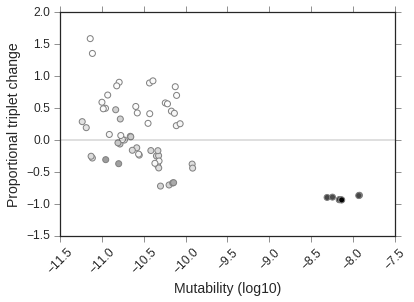

In [90]:
plt.scatter(plotting_df.muts_log10, plotting_df.trip_chnage, s = 36, color = plotting_df.adj_mut, edgecolor = "grey", cmap = "Greys")
plt.axhline(y = 0, linewidth = 0.25, color = "k")
plt.xticks(rotation=45, size = 12)
plt.yticks(size = 12)
plt.xlabel("Mutability (log10)", size = 14)
plt.ylabel("Proportional triplet change", size = 14)
# plt.xlim(left = 0, right = 0.0004)

#errobars
# plt.errorbar(triplet_muts_intron_log10, triplet_chnage_mean_intron, yerr = np.array(triplet_chnage_std_intron), ecolor = "grey", ls = "None")

plt.show()
# timestamp = datetime.now().strftime("%Y/%m/%d_%H:%M:%S").replace("/", "_").replace(":", "_")
# plt.tight_layout()
# plt.savefig("plots/Scatter_{t}_{l}Mbp_{p}gens_log_adjMut.png".format(p = gen_to_use, l = str(100000/1000000),t = timestamp))

In [87]:
plotting_df[(plotting_df.adj_mut > 0.00005)&(plotting_df.muts < 0.00002)]

,trip,muts,muts_log10,trip_chnage,adj_mut,precursor_mut
9,CTC,0.000015,-11.114237,-0.282573,0.000058,0.000015
12,GAG,0.000015,-11.129233,-0.254783,0.000060,0.000016
20,TTC,0.000014,-11.187263,0.193381,0.000052,0.000010
22,GAC,0.000017,-10.954671,-0.308227,0.000105,0.000012
56,AAC,0.000020,-10.835528,0.474294,0.000069,0.000015
62,GAA,0.000013,-11.235412,0.287887,0.000054,0.000010


** so GAC is low mut (-10.9is log) but decreases in freq (to half initial freq) as ACG adjacent mutates often destroying GAC **

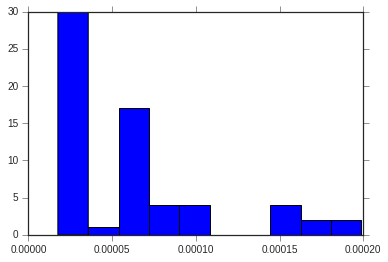

In [76]:
plt.hist(plotting_df.adj_mut)
plt.show()

In [92]:
# recall that non-cpg variation fromt he human mutability analysis notebook 
noncpg_min = 1.3198444035923253e-05
noncpg_max = 4.9361488694784825e-05

In [108]:
print("GAC is within the lowest", (model["GAC"][0]-noncpg_min)/(noncpg_max - noncpg_min), "% mut in or model")

GAC is within the lowest 0.11829049585121945 % mut in or model


## ** precursor analysis** 

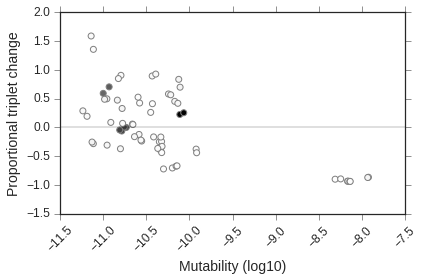

In [64]:
plt.scatter(plotting_df.muts_log10, plotting_df.trip_chnage, s = 36, color = plotting_df.precursor_mut, edgecolor = "grey", cmap = "Greys")
plt.axhline(y = 0, linewidth = 0.25, color = "k")
plt.xticks(rotation=45, size = 12)
plt.yticks(size = 12)
plt.xlabel("Mutability (log10)", size = 14)
plt.ylabel("Proportional triplet change", size = 14)
# plt.xlim(left = 0, right = 0.0004)

#errobars
# plt.errorbar(triplet_muts_intron_log10, triplet_chnage_mean_intron, yerr = np.array(triplet_chnage_std_intron), ecolor = "grey", ls = "None")

plt.show()
# timestamp = datetime.now().strftime("%Y/%m/%d_%H:%M:%S").replace("/", "_").replace(":", "_")
# plt.tight_layout()
# plt.savefig("plots/Scatter_{t}_{l}Mbp_{p}gens_log_precursorMut.png".format(p = gen_to_use, l = str(100000/1000000),t = timestamp))

In [75]:
# precursor_mut_tripEx = ["ATG", "CAT"]

# for triplet in precursor_mut_tripEx: 
#     for base in bases: 
#         precursor_trip = triplet[0]+base+triplet[2]
#         if triplet != precursor_trip: 
#             print(triplet, model[triplet][0], precursor_trip, model[precursor_trip][0], model[precursor_trip][1][triplet])

In [74]:
# for key, value in model.items(): 
#     if "CG" in key: 
#         print(key, value)

** so the triplets are CAT and ATG for precursor example** 
- they are the most liekly (90%) offsrping of CpG mutators (the most mutable CpGs too) 

In [106]:
print("CAT is within the hgihest", (noncpg_max-model["CAT"][0])/(noncpg_max - noncpg_min), "% mut in or model")

CAT is within the hgihest 0.18929104176733502 % mut in or model


In [109]:
print("ATG is within the hgihest", (noncpg_max-model["ATG"][0])/(noncpg_max - noncpg_min), "% mut in or model")

ATG is within the hgihest 0.24176561344998782 % mut in or model


In [103]:
noncpg_max

4.9361488694784825e-05

In [110]:
model["CAT"], model["ATG"]

([4.251614829783026e-05,
  {'CCT': 0.13864306784660768,
   'CGT': 0.7130214917825537,
   'CTT': 0.1483354403708386}],
 [4.061850801861585e-05,
  {'AAG': 0.15121951219512195,
   'ACG': 0.720620842572062,
   'AGG': 0.12815964523281598}])

In [111]:
noncpg_min

1.3198444035923253e-05

In [112]:
(4.9-4.25)/(4.9-1.32)

0.18156424581005595